In [14]:
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D,ZeroPadding2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD,RMSprop,Adam,Adamax
from keras.layers.advanced_activations import LeakyReLU
import time

import cv2
# warnings.filterwarnings('ignore')


In [23]:
import os
path = os.path.join(os.getcwd(),'sketch-data')
image = os.path.join(path,'image')
_input = os.path.join(path,'input_t')
output = os.path.join(path,'output_t')
edges = os.path.join(path,'edge')

In [24]:
class DCGAN(object):
    def __init__(self, img_rows=128, img_cols=128, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 32
        dropout = 0.4
        # In: 128 x 128 x 1, depth = 1
        # Out: 64 x 64 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))

        
        self.D.add(Conv2D(depth*16, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))
        
        

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
#         self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 32*4
        _id = 32
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        
        input_shape = (self.img_rows, self.img_cols, self.channel+1)
        self.G.add(Conv2D(_id, 5, strides=1, input_shape=input_shape,\
            padding='same'))
        self.G.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))
        #128X128X32/64

        self.G.add(Conv2D(_id*2, 5, strides=2, padding='same'))
        self.G.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))
#         64X64X64/128
        
        
        self.G.add(Conv2D(_id*4, 5, strides=2, padding='same'))
        self.G.add(LeakyReLU(alpha=0.2))
        self.G.add(BatchNormalization(momentum=0.9))
        self.D.add(Dropout(dropout))
        #32X32X128/256
#         self.D.add(Conv2D(_id*4, 5, strides=1, padding='same'))
#         self.D.add(LeakyReLU(alpha=0.2))
#         self.D.add(Dropout(dropout))
#         #32X32X256
#         self.G.add(Dense(dim*dim*depth, input_dim=100))
#         self.G.add(BatchNormalization(momentum=0.9))
#         self.G.add(Activation('relu'))
#         self.G.add(Reshape((dim, dim, depth)))
#         self.G.add(Dropout(dropout))

#         # In: dim x dim x depth
#         # Out: 2*dim x 2*dim x depth/2
#         self.G.add(UpSampling2D())
#         self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
#         self.G.add(BatchNormalization(momentum=0.9))
#         self.G.add(Activation('relu'))
#         # 32X32X128
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
#         64X64X32/64
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        #128X128X16/32
        
        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
#         self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = Adamax(lr=0.0001,  decay=3e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer =  Adamax(lr=0.0001,  decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM


In [25]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [26]:
class SKETCH_CGAN(object):
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channel = 1
#         (x_train, y_train), (x_test, y_test) = mnist.load_data()
#         self.x_train = x_train[:len(x_train)/10]
#         import numpy as np
#         x_train = []
#         for img in os.listdir(_input):
#             x_train+= [cv2.imread(os.path.join(_input,img),0)]
#         self.x_train = np.array(x_train)
# #         x_train.shape
#         self.x_train = self.x_train.reshape(-1, self.img_rows,\
#         	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=200, batch_size=256, save_interval=0):
#         noise_input = None
#         if save_interval>0:
#             noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        edges = []
        edge_list = list(os.listdir(output))
        for img in os.listdir(output):
                edges.append(cv2.imread(os.path.join(output,img),0))
        edges = np.array(edges)
        edges = edges.reshape(-1, self.img_rows,\
                self.img_cols, 1).astype(np.float32)
        real = []
        real_list = list(os.listdir(_input))
        for img in os.listdir(_input):
                real.append(cv2.imread(os.path.join(_input,img),0))
        real = np.array(real)
        real = real.reshape(-1, self.img_rows,\
                self.img_cols, 1).astype(np.float32)
#         batch_size = mat.shape[0]
        for i in range(train_steps):
#             print i
            
#                 images_train = self.x_train[np.random.randint(0,
#                     self.x_train.shape[0], size=batch_size), :, :, :]
#                 noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            n = 20
            for j in range(n-1):
#                 print i,j
                batch_size = int(len(edge_list)/n)
                noise = np.random.uniform(-1.0, 1.0, size=[128, 128]).reshape(128,128,1)
#                 print noise.shape, edges[j*batch_size:(j+1)*batch_size][0].shape
                _in = np.array([np.concatenate((x,noise),axis=2) for x in edges[j*batch_size:(j+1)*batch_size]])
#                 print _in.shape
                _real = real[j*batch_size:(j+1)*batch_size]
                images_fake = self.generator.predict(_in)
#                 print _in.shape,_real.shape,images_fake.shape
                x = np.concatenate((_real, images_fake))
#                 print 'concat'
                y = np.ones([2*batch_size, 1])
#                 print 'y'
                y[batch_size:, :] = 0
                d_loss = self.discriminator.train_on_batch(x, y)
#                 print 'train'

                y = np.ones([batch_size, 1])
    #             noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
                a_loss = self.adversarial.train_on_batch(_in, y)
            
#                 print 'train'
                log_mesg = "%d,%d: [D loss: %f, acc: %f]" % (i,j, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
#             if save_interval>0:
#                 if (i+1)%save_interval==0:
#                     self.plot_images(save2file=True, samples=noise_input.shape[0],\
#                         noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'sketches'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename+str(fake)+".png")
            plt.close('all')
        else:
            plt.show()


In [ ]:
mnist_dcgan = SKETCH_CGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=25, batch_size=256, save_interval=500)
timer.elapsed_time()


0,0: [D loss: 1.296905, acc: 0.450000]  [A loss: 12.894476, acc: 0.000000]
0,1: [D loss: 0.489741, acc: 0.850000]  [A loss: 10.084333, acc: 0.200000]
0,2: [D loss: 0.111999, acc: 1.000000]  [A loss: 5.312896, acc: 0.500000]
0,3: [D loss: 0.091334, acc: 1.000000]  [A loss: 8.383512, acc: 0.200000]
0,4: [D loss: 0.077099, acc: 1.000000]  [A loss: 11.460635, acc: 0.300000]
0,5: [D loss: 0.037126, acc: 1.000000]  [A loss: 11.300654, acc: 0.300000]
0,6: [D loss: 0.034720, acc: 1.000000]  [A loss: 12.894476, acc: 0.000000]
0,7: [D loss: 0.055721, acc: 1.000000]  [A loss: 10.012346, acc: 0.000000]
0,8: [D loss: 0.057242, acc: 0.950000]  [A loss: 16.118095, acc: 0.000000]
0,9: [D loss: 0.003083, acc: 1.000000]  [A loss: 8.401842, acc: 0.000000]
0,10: [D loss: 0.006797, acc: 1.000000]  [A loss: 12.894476, acc: 0.000000]
0,11: [D loss: 0.005860, acc: 1.000000]  [A loss: 14.701714, acc: 0.000000]
0,12: [D loss: 0.006301, acc: 1.000000]  [A loss: 12.894476, acc: 0.000000]
0,13: [D loss: 0.052126, 

5,14: [D loss: 0.000120, acc: 1.000000]  [A loss: 14.506287, acc: 0.000000]
5,15: [D loss: 0.000026, acc: 1.000000]  [A loss: 14.506287, acc: 0.000000]
5,16: [D loss: 0.002653, acc: 1.000000]  [A loss: 9.979334, acc: 0.100000]
5,17: [D loss: 0.015472, acc: 1.000000]  [A loss: 13.296560, acc: 0.000000]
5,18: [D loss: 0.000038, acc: 1.000000]  [A loss: 8.595916, acc: 0.000000]
6,0: [D loss: 0.000415, acc: 1.000000]  [A loss: 11.695608, acc: 0.100000]
6,1: [D loss: 0.000068, acc: 1.000000]  [A loss: 12.894476, acc: 0.000000]
6,2: [D loss: 0.000210, acc: 1.000000]  [A loss: 6.798774, acc: 0.600000]
6,3: [D loss: 0.000785, acc: 1.000000]  [A loss: 5.744164, acc: 0.200000]
6,4: [D loss: 0.002284, acc: 1.000000]  [A loss: 11.282667, acc: 0.000000]
6,5: [D loss: 0.000063, acc: 1.000000]  [A loss: 14.506287, acc: 0.000000]
6,6: [D loss: 0.000043, acc: 1.000000]  [A loss: 11.486480, acc: 0.100000]
6,7: [D loss: 0.000928, acc: 1.000000]  [A loss: 16.118095, acc: 0.000000]
6,8: [D loss: 0.000022, 

11,9: [D loss: 0.000014, acc: 1.000000]  [A loss: 9.857197, acc: 0.000000]
11,10: [D loss: 0.000026, acc: 1.000000]  [A loss: 11.342498, acc: 0.300000]
11,11: [D loss: 0.000036, acc: 1.000000]  [A loss: 12.894476, acc: 0.000000]
11,12: [D loss: 0.000160, acc: 1.000000]  [A loss: 14.506287, acc: 0.000000]
11,13: [D loss: 0.001850, acc: 1.000000]  [A loss: 12.910067, acc: 0.100000]
11,14: [D loss: 0.000204, acc: 1.000000]  [A loss: 12.894476, acc: 0.000000]
11,15: [D loss: 0.000015, acc: 1.000000]  [A loss: 16.118095, acc: 0.000000]
11,16: [D loss: 0.000462, acc: 1.000000]  [A loss: 11.622545, acc: 0.000000]
11,17: [D loss: 0.000867, acc: 1.000000]  [A loss: 11.282667, acc: 0.100000]
11,18: [D loss: 0.000036, acc: 1.000000]  [A loss: 14.506287, acc: 0.000000]
12,0: [D loss: 0.001361, acc: 1.000000]  [A loss: 7.244349, acc: 0.000000]
12,1: [D loss: 0.000045, acc: 1.000000]  [A loss: 6.826260, acc: 0.100000]
12,2: [D loss: 0.000269, acc: 1.000000]  [A loss: 8.374071, acc: 0.100000]
12,3: [

In [ ]:
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False)

In [ ]:
mnist_dcgan.discriminator

In [3]:
generator = keras.models.load_model('gen.pkl')

/usr/local/lib/python2.7/dist-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
import os 
edges = list(os.listdir(_input))

(1, 128, 128, 1)
(1, 128, 128, 2)


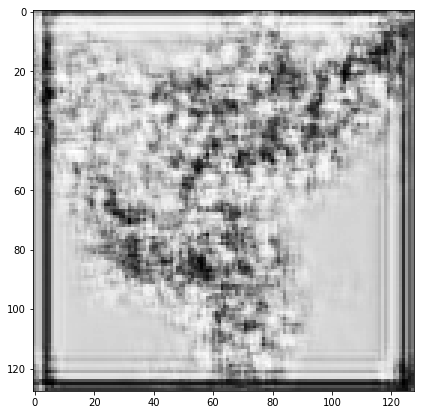

In [21]:
im = cv2.imread(os.path.join(output,'4612.jpg'),0)
# print im
im = np.array(im)
# print im.shape
im = im.reshape(-1, 128, 128, 1).astype(np.float32)
print im.shape
noise = np.random.uniform(-1.0, 1.0, size=[128, 128]).reshape(1,128,128,1)
im = np.concatenate((im,noise),axis=3)
print im.shape
gen = mnist_dcgan.generator.predict(im)*256
# print gen
import matplotlib.pyplot as plot
#fro
_gen = gen[0].reshape(128,128)
plot.imshow(_gen,cmap='gray')
plot.show()

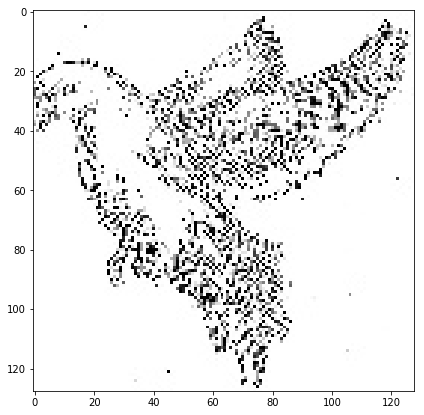

In [16]:
im = cv2.imread(os.path.join(output,'4612.jpg'),0)
plot.imshow(im,cmap='gray')
plot.show()

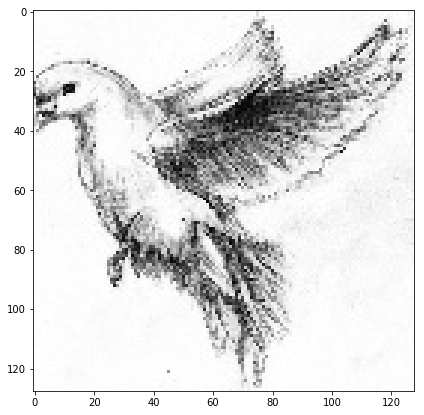

In [17]:
im = cv2.imread(os.path.join(_input,'4612.jpg'),0)
plot.imshow(im,cmap='gray')
plot.show()

In [41]:
noise = np.random.uniform(-1.0, 1.0, size=[128, 128])

In [42]:
noise.shape

(128, 128)

In [43]:
noise[:5,:5]

array([[ 0.89828601, -0.05865375, -0.27799265,  0.72930876,  0.88466486],
       [ 0.71660532,  0.90215027,  0.40075049,  0.15601035,  0.67216671],
       [ 0.92153292, -0.33794261,  0.57842439, -0.08574355,  0.64489386],
       [ 0.53479806,  0.84807254,  0.07388406, -0.9908887 , -0.87562046],
       [-0.23428087,  0.41516224, -0.65039589, -0.95102214,  0.63345637]])